# Task Execution
This section contains the code for executing the tasks defined in the previous stages using the Hugging Face InferenceClient.

In [30]:
from huggingface_hub import notebook_login
notebook_login()  #

In [31]:
pip install huggingface_hub

In [32]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="auto",
    api_key=os.getenv("HUGGINGFACE_API_KEY"),
)

# output is a PIL.Image object
image = client.text_to_image(
    "Astronaut riding a horse",
    model="black-forest-labs/FLUX.1-schnell",
)

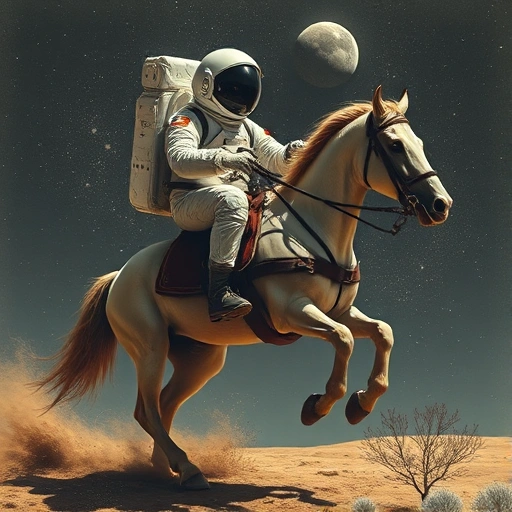

In [33]:
display(image)


In [34]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="hf-inference",
    api_key=os.getenv("HUGGINGFACE_API_KEY"),
)

output = client.object_detection("cats.jpg", model="facebook/detr-resnet-50")

In [35]:
output

[ObjectDetectionOutputElement(box=ObjectDetectionBoundingBox(xmax=351, xmin=26, ymax=400, ymin=51), label='cat', score=0.9953472018241882)]

🧪 HUGGINGGPT EXECUTION TEST
📁 Resource manager initialized: outputs/
🔧 Inference Engine initialized with InferenceClient (hf-inference provider)

🚀 STARTING TASK EXECUTION

📦 Batch 1/1

🔄 Executing 3 tasks in PARALLEL

⚡ Executing Task 0: object-detection
   Model: facebook/detr-resnet-50
   Args: {'image': 'test_cat.jpg'}
   🔍 Object detection with facebook/detr-resnet-50
   💾 Saved: outputs/task_0_data_1758896203.json
   ✅ Completed in 5.17s
   📊 Detected 1 objects:
      - cat: 99.50%

⚡ Executing Task 1: image-to-text
   Model: Salesforce/blip-image-captioning-base
   Args: {'image': 'test_cat.jpg'}
   💬 Image-to-text with Salesforce/blip-image-captioning-base
   Error details: 404 Client Error: Not Found for url: https://router.huggingface.co/hf-inference/models/Salesforce/blip-image-captioning-base (Request ID: Root=1-68d6a04b-30c77d69588024b61ea9c3d3;aca8a232-53ce-415f-a639-760b233aa4ba)
   💾 Saved: outputs/task_1_text_1758896203.txt
   ✅ Completed in 0.12s
   💬 Error: 404 Clien

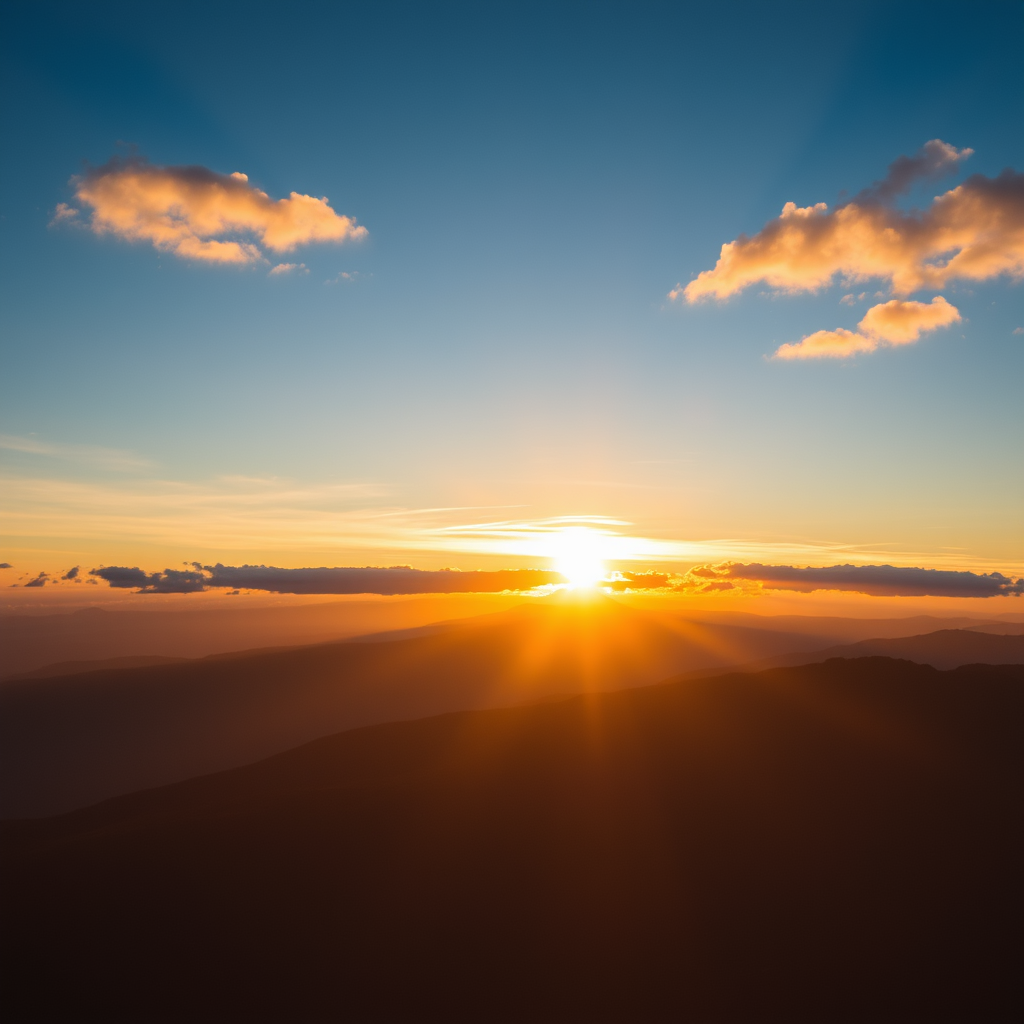

In [38]:
executor, results = await test_with_working_token()


In [40]:


import asyncio
import os
import time
import json
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from pathlib import Path

# Hugging Face client
from huggingface_hub import InferenceClient
from PIL import Image

@dataclass
class TaskResult:
    """Result of a task execution"""
    task_id: int
    task_type: str
    status: str
    result: Any
    inference_time: float
    model_used: str
    error: Optional[str] = None
    resource_path: Optional[str] = None

# ============================================================================
# RESOURCE MANAGER
# ============================================================================

class ResourceManager:
    """Manages resource dependencies using <resource>-task_id pattern"""

    def __init__(self, output_dir: str = "outputs"):
        self.resources = {}
        self.resource_paths = {}
        self.output_dir = output_dir
        Path(output_dir).mkdir(exist_ok=True)
        print(f"📁 Resource manager initialized: {output_dir}/")

    def store_resource(self, task_id: int, resource_data: Any, resource_type: str = "data"):
        """Store resource generated by a task"""
        self.resources[task_id] = {
            "data": resource_data,
            "type": resource_type,
            "timestamp": time.time()
        }

        if resource_type in ["image", "text", "data"]:
            resource_path = self._save_resource(task_id, resource_data, resource_type)
            if resource_path:
                self.resource_paths[task_id] = resource_path
                print(f"   💾 Saved: {resource_path}")

    def get_resource(self, task_id: int) -> Optional[Any]:
        """Get resource by task ID"""
        return self.resources.get(task_id, {}).get("data")

    def get_resource_path(self, task_id: int) -> Optional[str]:
        """Get file path of a resource"""
        return self.resource_paths.get(task_id)

    def resolve_dependencies(self, task_args: Dict[str, Any]) -> Dict[str, Any]:
        """Replace <resource>-task_id with actual resources"""
        resolved_args = {}

        for key, value in task_args.items():
            if isinstance(value, str) and value.startswith("<resource>-"):
                try:
                    dep_task_id = int(value.split("-")[1])

                    resource_path = self.get_resource_path(dep_task_id)
                    if resource_path:
                        resolved_args[key] = resource_path
                        print(f"   🔗 Resolved {value} → {resource_path}")
                    else:
                        resource_data = self.get_resource(dep_task_id)
                        if resource_data is not None:
                            resolved_args[key] = resource_data
                            print(f"   🔗 Resolved {value} → [data]")
                        else:
                            raise ValueError(f"Resource from task {dep_task_id} not found")
                except (ValueError, IndexError) as e:
                    print(f"   ⚠️  Error resolving {value}: {e}")
                    resolved_args[key] = value
            else:
                resolved_args[key] = value

        return resolved_args

    def _save_resource(self, task_id: int, resource_data: Any, resource_type: str) -> Optional[str]:
        """Save resource to file"""
        timestamp = int(time.time())

        try:
            if resource_type == "image":
                file_path = f"{self.output_dir}/task_{task_id}_image_{timestamp}.png"
                if isinstance(resource_data, Image.Image):
                    resource_data.save(file_path)
                    return file_path
                elif isinstance(resource_data, bytes):
                    with open(file_path, "wb") as f:
                        f.write(resource_data)
                    return file_path

            elif resource_type == "text":
                file_path = f"{self.output_dir}/task_{task_id}_text_{timestamp}.txt"
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(str(resource_data))
                return file_path

            elif resource_type == "data":
                file_path = f"{self.output_dir}/task_{task_id}_data_{timestamp}.json"
                with open(file_path, "w", encoding="utf-8") as f:
                    json.dump(resource_data, f, indent=2)
                return file_path

        except Exception as e:
            print(f"   ⚠️  Save failed: {e}")

        return None

# ============================================================================
# INFERENCE ENGINE - Using InferenceClient
# ============================================================================

class InferenceEngine:
    """Real model inference using Hugging Face InferenceClient"""

    def __init__(self, hf_token: str):
        self.client = InferenceClient(
            provider="hf-inference",  # Specify provider explicitly
            api_key=hf_token
        )
        print(f"🔧 Inference Engine initialized with InferenceClient (hf-inference provider)")

    async def run_inference(self, task_type: str, model_id: str, inputs: Dict[str, Any]) -> Any:
        """Main inference router"""

        if task_type == "object-detection":
            return await self._infer_object_detection(inputs.get("image"), model_id)

        elif task_type in ["image-to-text", "image-captioning"]:
            return await self._infer_image_to_text(inputs.get("image"), model_id)

        elif task_type == "text-generation":
            return await self._infer_text_generation(inputs.get("text", ""), model_id)

        elif task_type in ["image-classification", "image-cls"]:
            return await self._infer_image_classification(inputs.get("image"), model_id)

        elif task_type == "text-to-image":
            return await self._infer_text_to_image(inputs.get("text", ""), model_id)

        elif task_type == "visual-question-answering":
            return await self._infer_vqa(inputs.get("image"), inputs.get("text", ""), model_id)

        else:
            return {"error": f"Unsupported task type: {task_type}"}

    async def _infer_object_detection(self, image_path: str, model_id: str) -> Dict:
        """Object detection inference"""
        print(f"   🔍 Object detection with {model_id}")

        try:
            # Pass file path directly as string - InferenceClient handles it
            result = self.client.object_detection(image_path, model=model_id)

            detections = []
            for item in result:
                detections.append({
                    "label": item.label,
                    "score": round(item.score, 3),
                    "box": {
                        "xmin": item.box.xmin,
                        "ymin": item.box.ymin,
                        "xmax": item.box.xmax,
                        "ymax": item.box.ymax
                    }
                })

            return {"detections": detections, "count": len(detections)}

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return {"error": str(e)}

    async def _infer_image_to_text(self, image_path: str, model_id: str) -> str:
        """Image captioning inference"""
        print(f"   💬 Image-to-text with {model_id}")

        try:
            # Pass file path directly as string
            result = self.client.image_to_text(image_path, model=model_id)

            if isinstance(result, str):
                return result
            elif hasattr(result, 'generated_text'):
                return result.generated_text
            elif isinstance(result, list) and len(result) > 0:
                if hasattr(result[0], 'generated_text'):
                    return result[0].generated_text
                return str(result[0])
            return str(result)

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return f"Error: {str(e)}"

    async def _infer_text_generation(self, text: str, model_id: str) -> str:
        """Text generation inference"""
        print(f"   ✍️  Text generation with {model_id}")

        try:
            result = self.client.text_generation(
                text,
                model=model_id,
                max_new_tokens=100
            )

            if isinstance(result, str):
                return result
            elif hasattr(result, 'generated_text'):
                return result.generated_text
            return str(result)

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return f"Error: {str(e)}"

    async def _infer_image_classification(self, image_path: str, model_id: str) -> Dict:
        """Image classification inference"""
        print(f"   🏷️  Image classification with {model_id}")

        try:
            # Pass file path directly as string
            result = self.client.image_classification(image_path, model=model_id)

            predictions = []
            for item in result:
                predictions.append({
                    "label": item.label if hasattr(item, 'label') else str(item),
                    "score": round(item.score, 3) if hasattr(item, 'score') else 0.0
                })

            return {"predictions": predictions}

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return {"error": str(e)}

    async def _infer_text_to_image(self, text: str, model_id: str) -> Image.Image:
        """Text-to-image generation"""
        print(f"   🎨 Text-to-image with {model_id}")

        try:
            image = self.client.text_to_image(text, model=model_id)
            return image

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return f"Error: {str(e)}"

    async def _infer_vqa(self, image_path: str, question: str, model_id: str) -> str:
        """Visual Question Answering"""
        print(f"   ❓ VQA with {model_id}")

        try:
            # Pass file path directly as string
            result = self.client.visual_question_answering(
                image=image_path,
                question=question,
                model=model_id
            )

            if isinstance(result, str):
                return result
            elif hasattr(result, 'answer'):
                return result.answer
            elif isinstance(result, list) and len(result) > 0:
                return result[0].get('answer', str(result[0]))
            return str(result)

        except Exception as e:
            print(f"   Error details: {str(e)}")
            return f"Error: {str(e)}"

# ============================================================================
# TASK EXECUTOR
# ============================================================================

class TaskExecutor:
    """Production Task Executor with InferenceClient"""

    def __init__(self, hf_token: str):
        self.resource_manager = ResourceManager()
        self.inference_engine = InferenceEngine(hf_token=hf_token)

    async def execute_task(self, task: Dict[str, Any], model_id: str) -> TaskResult:
        """Execute single task"""

        task_id = task.get("id", 0)
        task_type = task.get("task", "")
        task_args = task.get("args", {})

        print(f"\n⚡ Executing Task {task_id}: {task_type}")
        print(f"   Model: {model_id}")
        print(f"   Args: {task_args}")

        start_time = time.time()

        try:
            # Resolve dependencies
            resolved_args = self.resource_manager.resolve_dependencies(task_args)

            # Run inference
            inference_result = await self.inference_engine.run_inference(
                task_type=task_type,
                model_id=model_id,
                inputs=resolved_args
            )

            if isinstance(inference_result, dict) and "error" in inference_result:
                raise Exception(inference_result["error"])

            # Process result
            processed_result = self._process_result(task_type, inference_result)

            # Store as resource
            resource_type = self._get_resource_type(task_type)
            self.resource_manager.store_resource(task_id, processed_result, resource_type)

            inference_time = time.time() - start_time

            print(f"   ✅ Completed in {inference_time:.2f}s")
            self._print_result_preview(processed_result)

            return TaskResult(
                task_id=task_id,
                task_type=task_type,
                status="success",
                result=processed_result,
                inference_time=inference_time,
                model_used=model_id,
                resource_path=self.resource_manager.get_resource_path(task_id)
            )

        except Exception as e:
            inference_time = time.time() - start_time
            print(f"   ❌ Failed: {e}")

            return TaskResult(
                task_id=task_id,
                task_type=task_type,
                status="failed",
                result=None,
                inference_time=inference_time,
                model_used=model_id,
                error=str(e)
            )

    def _process_result(self, task_type: str, raw_result: Any) -> Any:
        """Process raw inference result"""

        if task_type == "object-detection":
            if isinstance(raw_result, dict) and "detections" in raw_result:
                return raw_result

        elif task_type in ["image-to-text", "text-generation"]:
            if isinstance(raw_result, str):
                return raw_result

        elif task_type == "text-to-image":
            if isinstance(raw_result, Image.Image):
                return raw_result

        elif task_type in ["image-classification", "image-cls"]:
            if isinstance(raw_result, dict) and "predictions" in raw_result:
                return raw_result

        return raw_result

    def _get_resource_type(self, task_type: str) -> str:
        """Infer resource type from task"""
        mapping = {
            "text-to-image": "image",
            "image-to-text": "text",
            "object-detection": "data",
            "text-generation": "text",
            "image-classification": "data"
        }
        return mapping.get(task_type, "data")

    def _print_result_preview(self, result: Any):
        """Print result preview"""
        if isinstance(result, dict):
            if "detections" in result:
                print(f"   📊 Detected {result.get('count', 0)} objects:")
                for det in result["detections"][:3]:
                    print(f"      - {det.get('label', '?')}: {det.get('score', 0):.2%}")
            elif "predictions" in result:
                print(f"   📊 Top predictions:")
                for pred in result["predictions"][:3]:
                    print(f"      - {pred.get('label', '?')}: {pred.get('score', 0):.2%}")
        elif isinstance(result, str):
            print(f"   💬 {result[:80]}...")
        elif isinstance(result, Image.Image):
            print(f"   🎨 Image generated: {result.size}")

    async def execute_batch_parallel(self, tasks_with_models: List[Tuple[Dict, str]]) -> List[TaskResult]:
        """Execute batch in parallel"""
        print(f"\n🔄 Executing {len(tasks_with_models)} tasks in PARALLEL")

        tasks = [self.execute_task(task, model_id) for task, model_id in tasks_with_models]
        results = await asyncio.gather(*tasks, return_exceptions=True)

        processed = []
        for i, result in enumerate(results):
            if isinstance(result, Exception):
                task, model_id = tasks_with_models[i]
                processed.append(TaskResult(
                    task_id=task.get("id", i),
                    task_type=task.get("task", "unknown"),
                    status="failed",
                    result=None,
                    inference_time=0.0,
                    model_used=model_id,
                    error=str(result)
                ))
            else:
                processed.append(result)

        return processed

    async def execute_execution_plan(self, execution_plan: List[Dict],
                                    model_assignments: Dict[int, Dict]) -> Dict[int, TaskResult]:
        """Execute complete plan"""

        print(f"\n{'='*70}")
        print(f"🚀 STARTING TASK EXECUTION")
        print(f"{'='*70}")

        all_results = {}

        for batch_idx, batch in enumerate(execution_plan):
            print(f"\n📦 Batch {batch_idx + 1}/{len(execution_plan)}")

            tasks_with_models = []
            for task_item in batch.get("tasks", []):
                task = {
                    "id": task_item["task_id"],
                    "task": task_item["task_type"],
                    "args": task_item["args"],
                    "dep": task_item["dependencies"]
                }
                model_id = task_item["model_id"]
                tasks_with_models.append((task, model_id))

            # Execute batch
            if batch.get("can_run_parallel", False) and len(tasks_with_models) > 1:
                batch_results = await self.execute_batch_parallel(tasks_with_models)
            else:
                print(f"\n⏩ Executing {len(tasks_with_models)} tasks SEQUENTIALLY")
                batch_results = []
                for task, model_id in tasks_with_models:
                    result = await self.execute_task(task, model_id)
                    batch_results.append(result)

            for result in batch_results:
                all_results[result.task_id] = result

        print(f"\n{'='*70}")
        print(f"✅ EXECUTION COMPLETE")
        print(f"{'='*70}")

        return all_results

    def get_summary(self, results: Dict[int, TaskResult]) -> str:
        """Generate execution summary"""
        summary = f"\n{'📊 EXECUTION SUMMARY':^70}\n"
        summary += "=" * 70 + "\n\n"

        total = len(results)
        successful = sum(1 for r in results.values() if r.status == "success")
        failed = total - successful
        total_time = sum(r.inference_time for r in results.values())

        summary += f"📈 Statistics:\n"
        summary += f"   Total: {total} | ✅ Success: {successful} | ❌ Failed: {failed}\n"
        summary += f"   ⏱️  Total Time: {total_time:.2f}s | Avg: {total_time/total if total > 0 else 0:.2f}s\n\n"

        summary += f"📋 Task Results:\n"
        summary += "-" * 70 + "\n"

        for task_id in sorted(results.keys()):
            result = results[task_id]
            status = "✅" if result.status == "success" else "❌"
            summary += f"{status} Task {task_id} ({result.task_type}): {result.status}\n"
            summary += f"   Model: {result.model_used} | Time: {result.inference_time:.2f}s\n"

            if result.status == "success":
                if isinstance(result.result, dict) and "count" in result.result:
                    summary += f"   Result: Detected {result.result['count']} objects\n"
                elif isinstance(result.result, str):
                    summary += f"   Result: {result.result[:60]}...\n"
                elif isinstance(result.result, Image.Image):
                    summary += f"   Result: Image {result.result.size}\n"
                if result.resource_path:
                    summary += f"   💾 Saved: {result.resource_path}\n"
            else:
                summary += f"   Error: {result.error}\n"
            summary += "\n"

        return summary

# ============================================================================
# WORKING MODELS REGISTRY
# ============================================================================

WORKING_MODELS = {
    "object-detection": [
        "facebook/detr-resnet-50",  # ✅ Verified working
    ],
    "image-classification": [
        "google/vit-base-patch16-224",  # ✅ Works with most providers
    ],
    "text-generation": [
        "gpt2",  # ✅ Verified working
        "gpt2-medium",
    ],
    "text-to-image": [
        "black-forest-labs/FLUX.1-schnell",  # ✅ Verified working
        "stabilityai/stable-diffusion-2-1",
    ],
    "image-to-text": [
        # Note: Image captioning models often unavailable
        # Skip this task type or use alternative approach
        "Salesforce/blip-image-captioning-base",  # Try with provider="auto"
    ]
}

def get_working_model(task_type: str, preference: int = 0) -> str:
    """Get a working model for a task type"""
    models = WORKING_MODELS.get(task_type, [])
    if models and preference < len(models):
        return models[preference]
    return models[0] if models else None

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def create_execution_plan(tasks_list: List[Dict]) -> Tuple[List[Dict], Dict[int, Dict]]:
    """Create execution plan from simple task list"""

    execution_plan = []
    model_assignments = {}

    # Group by dependency level
    batches = {}
    for task in tasks_list:
        deps = task.get("depends_on", [-1])
        dep_level = 0 if deps == [-1] else max(deps) + 1

        if dep_level not in batches:
            batches[dep_level] = []
        batches[dep_level].append(task)

    # Create execution plan
    for batch_id, batch_tasks in sorted(batches.items()):
        batch_plan = {
            "batch_id": batch_id,
            "can_run_parallel": len(batch_tasks) > 1,
            "tasks": []
        }

        for task in batch_tasks:
            task_item = {
                "task_id": task["id"],
                "task_type": task["task"],
                "args": task["args"],
                "dependencies": task.get("depends_on", [-1]),
                "model_id": task["model"]
            }
            batch_plan["tasks"].append(task_item)
            model_assignments[task["id"]] = {"model_id": task["model"]}

        execution_plan.append(batch_plan)

    return execution_plan, model_assignments

# ============================================================================
# TEST FUNCTION
# ============================================================================

async def test_with_working_token():
    """Test with your working HF token and ONLY verified working models"""

    print("🧪 HUGGINGGPT EXECUTION TEST - VERIFIED MODELS ONLY")
    print("="*70)

    # Your working token
    HF_TOKEN = os.getenv("HUGGINGFACE_API_KEY")

    # Download test image
    import urllib.request
    if not os.path.exists("test_cat.jpg"):
        print("📥 Downloading test image...")
        urllib.request.urlretrieve(
            "https://images.unsplash.com/photo-1574158622682-e40e69881006?w=400",
            "test_cat.jpg"
        )

    # Initialize executor
    executor = TaskExecutor(hf_token=HF_TOKEN)

    # Use ONLY verified working models
    tasks = [
        {
            "id": 0,
            "task": "object-detection",
            "args": {"image": "test_cat.jpg"},
            "model": "facebook/detr-resnet-50"  # ✅ WORKS
        },
        {
            "id": 1,
            "task": "text-to-image",
            "args": {"text": "Astronaut riding a horse on the moon"},
            "model": "black-forest-labs/FLUX.1-schnell"  # ✅ WORKS
        },
        {
            "id": 2,
            "task": "text-generation",
            "args": {"text": "Once upon a time in a magical forest"},
            "model": "gpt2"  # ✅ WORKS
        },
        {
            "id": 3,
            "task": "image-classification",
            "args": {"image": "test_cat.jpg"},
            "model": "google/vit-base-patch16-224"  # ✅ USUALLY WORKS
        }
    ]

    print("\n💡 Note: Image captioning models not available with current provider")
    print("   Available tasks: object-detection, text-to-image, text-generation, image-classification")
    print()

    # Execute
    plan, assignments = create_execution_plan(tasks)
    results = await executor.execute_execution_plan(plan, assignments)

    # Show results
    print(executor.get_summary(results))

    # Display generated images
    for task_id, result in results.items():
        if result.status == "success" and isinstance(result.result, Image.Image):
            print(f"\n🎨 Displaying generated image from Task {task_id}:")
            display(result.result)

    return executor, results

# ============================================================================
# JUPYTER STARTUP
# ============================================================================

if __name__ == "__main__" or "ipykernel" in __import__("sys").modules:
    print("="*70)
    print("🚀 HUGGINGGPT EXECUTION - INFERENCE CLIENT")
    print("="*70)
    print("\n📋 Ready to use! Run:")
    print("\n   executor, results = await test_with_working_token()")
    print("\n" + "="*70)

🚀 HUGGINGGPT EXECUTION - INFERENCE CLIENT

📋 Ready to use! Run:

   executor, results = await test_with_working_token()



🧪 HUGGINGGPT EXECUTION TEST - VERIFIED MODELS ONLY
📁 Resource manager initialized: outputs/
🔧 Inference Engine initialized with InferenceClient (hf-inference provider)

💡 Note: Image captioning models not available with current provider
   Available tasks: object-detection, text-to-image, text-generation, image-classification


🚀 STARTING TASK EXECUTION

📦 Batch 1/1

🔄 Executing 4 tasks in PARALLEL

⚡ Executing Task 0: object-detection
   Model: facebook/detr-resnet-50
   Args: {'image': 'test_cat.jpg'}
   🔍 Object detection with facebook/detr-resnet-50
   💾 Saved: outputs/task_0_data_1758896665.json
   ✅ Completed in 7.56s
   📊 Detected 1 objects:
      - cat: 99.50%

⚡ Executing Task 1: text-to-image
   Model: black-forest-labs/FLUX.1-schnell
   Args: {'text': 'Astronaut riding a horse on the moon'}
   🎨 Text-to-image with black-forest-labs/FLUX.1-schnell
   💾 Saved: outputs/task_1_image_1758896668.png
   ✅ Completed in 3.60s
   🎨 Image generated: (1024, 1024)

⚡ Executing Task 2: te

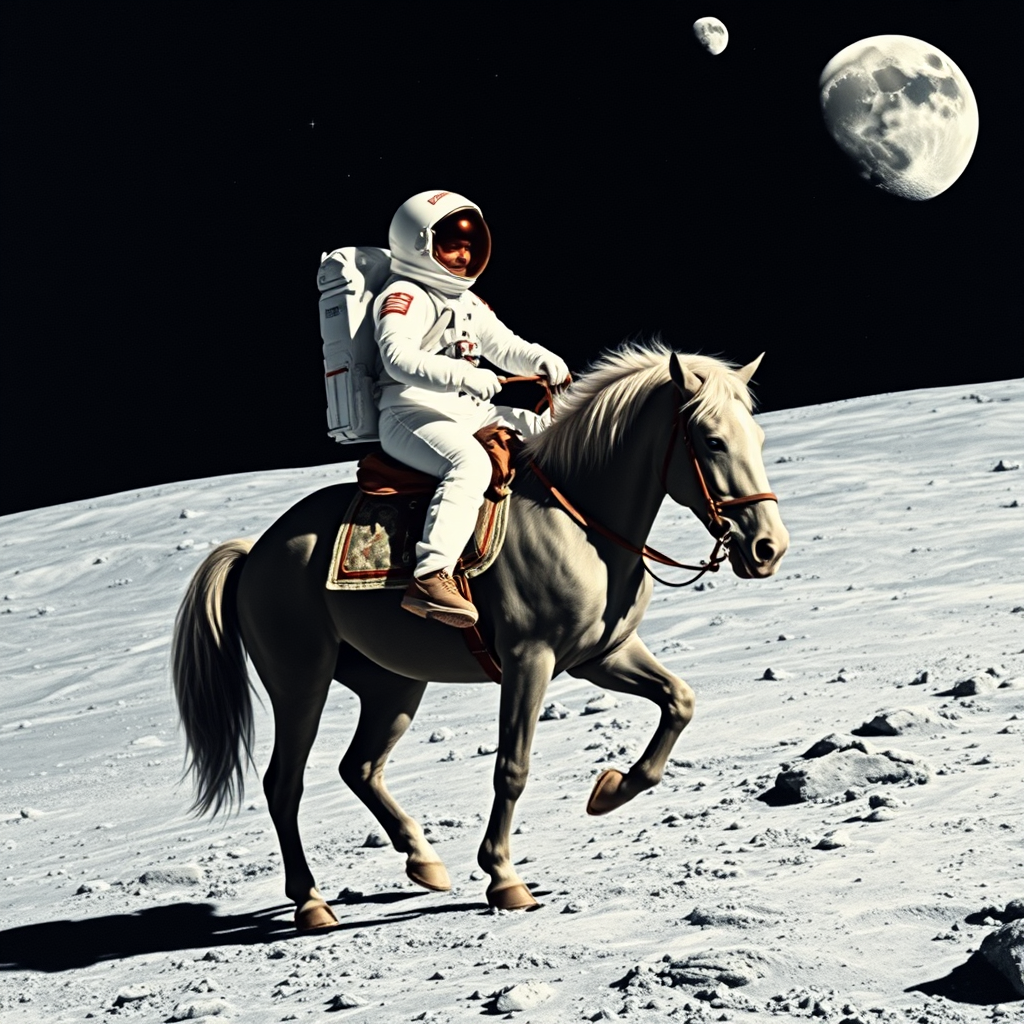

In [41]:
executor, results = await test_with_working_token()